In [1]:
# import os; os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [2]:
import tensorflow as tf; tf.test.is_gpu_available()

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-04-15 14:02:20.545213: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

2024-04-15 14:02:21.025497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 4140 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5


In [3]:
tf.__version__

'2.8.0'

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU devices found. TensorFlow will run on CPU.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11066466256622860422
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4341956608
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12616524624238224619
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2024-04-15 14:02:21.063746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 4140 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
## importing required packages
import numpy as np
from os import listdir
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
# import cv2
from keras.models import Model
from keras.layers import BatchNormalization, Conv2D, Activation, Dropout, AveragePooling2D, concatenate, GlobalAveragePooling2D, MaxPooling2D, Dense, Input, UpSampling2D
from keras.regularizers import l2
import keras.backend as K

import matplotlib.pyplot as plt

In [8]:
## CONFIGURATION 
EPOCHS = 10
BUFFER_SIZE = 2000
BATCH_SIZE = 1

IMG_HEIGHT = 256
IMG_WIDTH = 256

In [9]:
# image_dir = "/content/drive/My Drive/3d printer/codes/datasets/cropped-datasets/"
# masks_dir = "/content/drive/My Drive/3d printer/codes/datasets/ground-truth/"

image_dir = "./All_images/"
masks_dir = "./All_masks/"

In [10]:
# import glob
# img_files = glob.glob(image_dir + '/**/*.jpg', recursive=True)
# mask_files = glob.glob(masks_dir + '/**/*.png', recursive=True)
# img_files[:10], mask_files[:10]

In [11]:
img_folders = ['abyek_images', 'imgs_deliniation', 'original_bound_detection']
mask_folders = ['abyek_masks', 'masks_deliniation', 'img_bound_detection']

# img_folders = ['abyek_images', 'original_bound_detection']
# mask_folders = ['abyek_masks', 'img_bound_detection']

images_path, masks_path = [], []

for fol, mfol in zip(img_folders, mask_folders):
    images_list = listdir(image_dir + fol)
    masks_list = listdir(masks_dir + mfol)

    img_list = [i.split('.jpg')[0] for i in images_list]
    msk_list = [i.split('.png')[0] for i in masks_list]

    commons = list(set(img_list) & set(msk_list))

    ip =  [image_dir + fol + "/" + i + ".jpg"  for i in commons]
    mp  = [masks_dir + mfol + "/" + i + ".png"  for i in commons]

    images_path.extend(ip)
    masks_path.extend(mp)

In [12]:
images_path[:10], masks_path[:10] 

(['./All_images/abyek_images/222.jpg',
  './All_images/abyek_images/185.jpg',
  './All_images/abyek_images/536.jpg',
  './All_images/abyek_images/283.jpg',
  './All_images/abyek_images/806.jpg',
  './All_images/abyek_images/635.jpg',
  './All_images/abyek_images/1623.jpg',
  './All_images/abyek_images/546.jpg',
  './All_images/abyek_images/710.jpg',
  './All_images/abyek_images/504.jpg'],
 ['./All_masks/abyek_masks/222.png',
  './All_masks/abyek_masks/185.png',
  './All_masks/abyek_masks/536.png',
  './All_masks/abyek_masks/283.png',
  './All_masks/abyek_masks/806.png',
  './All_masks/abyek_masks/635.png',
  './All_masks/abyek_masks/1623.png',
  './All_masks/abyek_masks/546.png',
  './All_masks/abyek_masks/710.png',
  './All_masks/abyek_masks/504.png'])

In [13]:
def load_images(image_path, mask_path, img_size = (IMG_HEIGHT, IMG_WIDTH)):
  # load our images from the image and mask path
  img_data = tf.io.read_file(image_path)
  img = tf.io.decode_png(img_data,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)

  segm_data = tf.io.read_file(mask_path)
  mask = tf.io.decode_png(segm_data)
  mask = tf.math.reduce_max(mask, axis = -1, keepdims=True)
  mask = mask / 255

  img = tf.image.resize(img, img_size , method = 'nearest')
  mask = tf.image.resize(mask, img_size, method = 'nearest')
  
  return img, mask

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((images_path, masks_path))
dataset = dataset.map(load_images ,num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(BUFFER_SIZE)

2024-04-15 14:02:21.351176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4140 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5


In [15]:
seed = 123
# divide our dataset into training and test set
val_dataset = (dataset
               .take(300)
               .prefetch(buffer_size=tf.data.AUTOTUNE) 
               )
train_dataset = (dataset
                .skip(300)
                # .map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed)))
                # .map(lambda image, label: (tf.image.random_flip_left_right(image, seed=seed), tf.image.random_flip_left_right(label, seed=seed)))
                # .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=0.8), label))               
                .prefetch(buffer_size=tf.data.AUTOTUNE)
                # .repeat(2)
                ) 
# train_dataset = train_dataset.map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed))).repeat(1)

In [16]:
train_dataset.cardinality().numpy()

4021

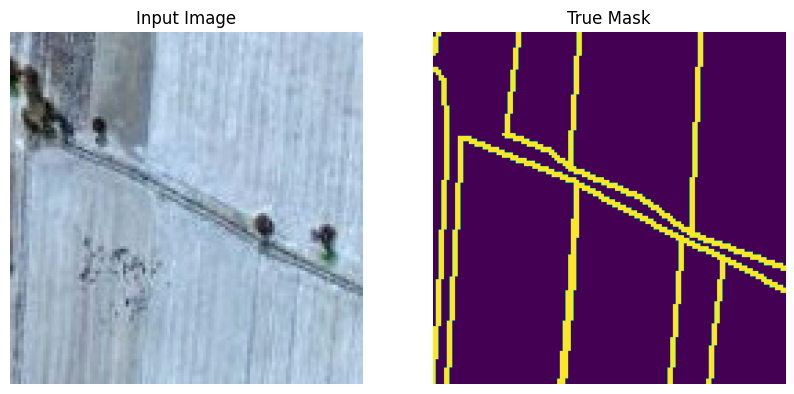

In [17]:
# plot images
def display(display_list):
  plt.figure(figsize=(10,10))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
    
N = 1
for image,mask in dataset.take(N):
  sample_image, sample_mask = image[0],mask[0]
  display([sample_image,sample_mask])
  

## Unet Model

In [18]:
def Conv_Block(input_tensor, filters, bottleneck=False, weight_decay=1e-4):

    concat_axis = 1 if K.image_data_format() == 'channel_first' else -1  # 确定格式

    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(input_tensor)
    x = Activation('relu')(x)

    # if bottleneck:
    #     inter_channel = filters
    #     x = Conv2D(inter_channel, (1, 1),
    #                kernel_initializer='he_normal',
    #                padding='same', use_bias=False,
    #                kernel_regularizer=l2(weight_decay))(x)
    #     x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
    #     x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False)(x)

    return x
def dens_block(input_tensor, nb_filter):
    x1 = Conv_Block(input_tensor,nb_filter)
    add1 = concatenate([x1, input_tensor], axis=-1)
    x2 = Conv_Block(add1,nb_filter)
    add2 = concatenate([x1, input_tensor,x2], axis=-1)
    x3 = Conv_Block(add2,nb_filter)
    return x3

In [19]:
#model definition
def denseunet():
    l1 = 4
    inputs = Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
    # x  = Conv2D(32, 1, strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    x = Conv2D(32, 7, kernel_initializer='he_normal', padding='same', strides=1,use_bias=False, kernel_regularizer=l2(1e-4))(inputs)
    #down first
    down1 = dens_block(x,nb_filter=l1*2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(down1)#256
    #down second
    down2 = dens_block(pool1,nb_filter=l1*4)
    pool2 = MaxPooling2D(pool_size=(2, 2))(down2)#128
    #down third
    down3 = dens_block(pool2,nb_filter=l1*8)
    pool3 = MaxPooling2D(pool_size=(2, 2))(down3)#64
    #down four
    down4 = dens_block(pool3,nb_filter=l1*16)
    pool4 = MaxPooling2D(pool_size=(2, 2))(down4)#32
    #center
    conv5 = Conv2D(l1*32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(l1*32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # up first
    up6 = UpSampling2D(size=(2, 2))(drop5)
    # up6 = UpSampling2D(size=(2, 2))(drop5)
    add6 = concatenate([down4, up6], axis=3)
    up6 = dens_block(add6,nb_filter=l1*16)
    # up second
    up7 = UpSampling2D(size=(2, 2))(up6)
    #up7 = UpSampling2D(size=(2, 2))(conv6)
    add7 = concatenate([down3, up7], axis=3)
    up7 = dens_block(add7,nb_filter=l1*8)
    # up third
    up8 = UpSampling2D(size=(2, 2))(up7)
    #up8 = UpSampling2D(size=(2, 2))(conv7)
    add8 = concatenate([down2, up8], axis=-1)
    up8 = dens_block(add8,nb_filter=l1*4)
    #up four
    up9 =UpSampling2D(size=(2, 2))(up8)
    add9 = concatenate([down1, up9], axis=-1)
    up9 = dens_block(add9,nb_filter=l1*2)
    # output
    conv10 = Conv2D(32, 7, strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv10)
    model = Model(inputs, conv10)
    # print(model.summary())
    return model

In [20]:
model = denseunet()

In [21]:
from tensorflow.keras.optimizers import Adam

model.compile(
     optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=['accuracy'],
  )

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  4704        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [23]:
callbacks = [
    # ReduceLROnPlateau(patience=3, verbose=1),
    # EarlyStopping(patience=12, verbose=1),
    ModelCheckpoint('DenseUnet-model.h5', verbose=0, save_best_only=True,save_weights_only=False)
    ]

In [24]:
  # fiting the model
history = model.fit(
      train_dataset,
      epochs=EPOCHS,
      validation_data = val_dataset,
      # validation_steps = 8,
      # batch_size=BATCH_SIZE,
      callbacks = callbacks, 
    )

Epoch 1/10


2024-04-15 14:02:25.581449: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8907


4021/4021 [==============================] - 105s 25ms/step - loss: 0.3218 - accuracy: 0.8721 - val_loss: 0.3896 - val_accuracy: 0.8629
Epoch 2/10
4021/4021 [==============================] - 99s 25ms/step - loss: 0.2951 - accuracy: 0.8795 - val_loss: 0.4313 - val_accuracy: 0.8665
Epoch 3/10
4021/4021 [==============================] - 100s 25ms/step - loss: 0.2848 - accuracy: 0.8820 - val_loss: 0.4917 - val_accuracy: 0.8660
Epoch 4/10
4021/4021 [==============================] - 100s 25ms/step - loss: 0.2787 - accuracy: 0.8837 - val_loss: 0.4331 - val_accuracy: 0.8651
Epoch 5/10
4021/4021 [==============================] - 100s 25ms/step - loss: 0.2759 - accuracy: 0.8843 - val_loss: 0.3886 - val_accuracy: 0.8708
Epoch 6/10
4021/4021 [==============================] - 99s 24ms/step - loss: 0.2704 - accuracy: 0.8856 - val_loss: 0.4294 - val_accuracy: 0.8695
Epoch 7/10
4021/4021 [==============================] - 100s 25ms/step - loss: 0.2703 - accuracy: 0.8858 - val_loss: 0.4046 - val_a

KeyboardInterrupt: 

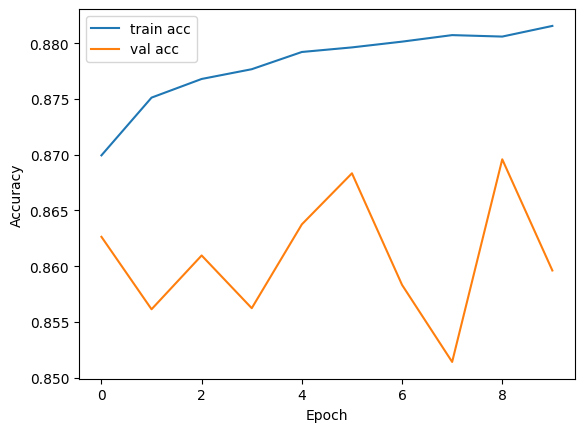

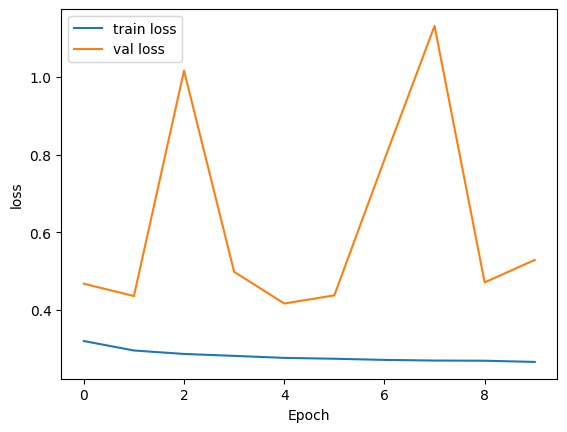

In [ ]:
plt.plot(history.history["accuracy"], label='train acc')
plt.plot(history.history["val_accuracy"], label='val acc')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history["loss"], label='train loss')
plt.plot(history.history["val_loss"], label='val loss')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
def create_mask(pred_mask):
    # pred_mask = tf.argmax(pred_mask, axis=-1)
    pred = pred_mask[0]
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0

    # pred_mask = pred_mask[..., tf.newaxis]
    return pred

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image, verbose=0)
            # print(pred_mask[0][pred_mask[0]>0.5])
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

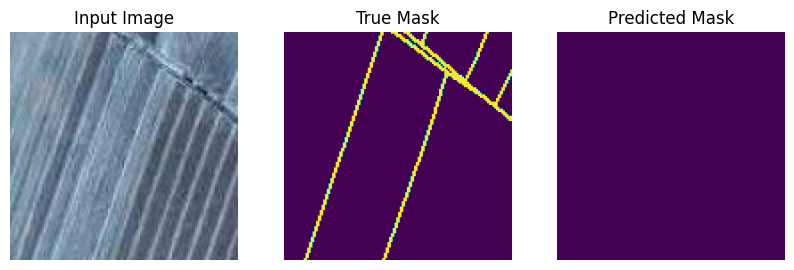

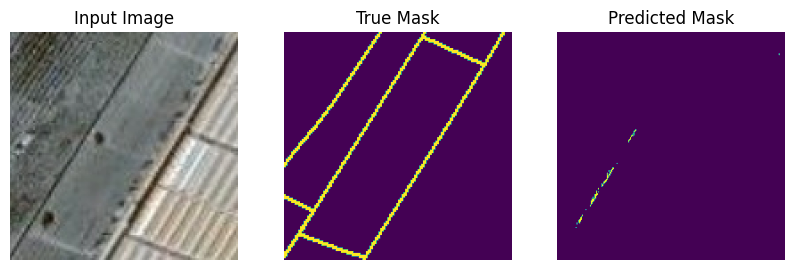

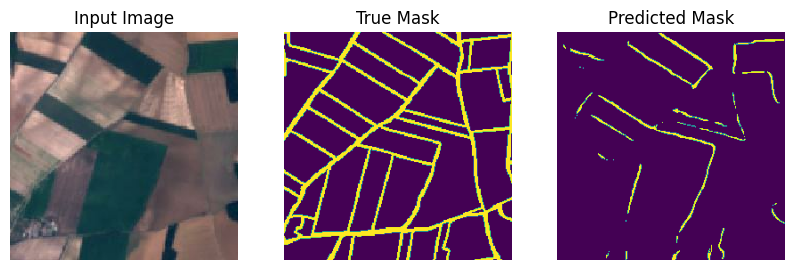

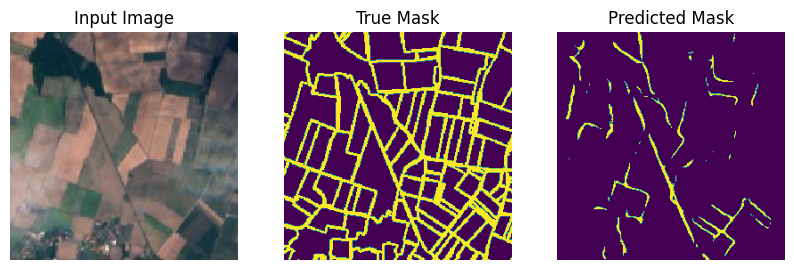

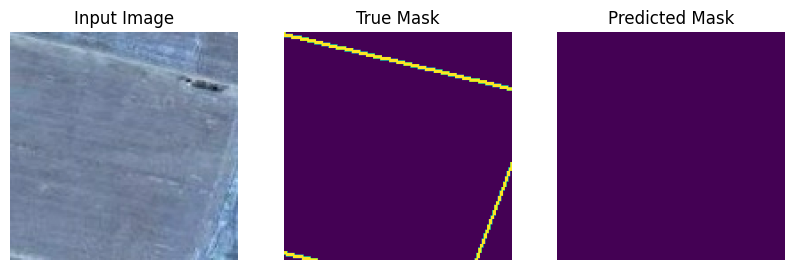

In [ ]:
## displaying our result
show_predictions(val_dataset,num=5)